#Overwatch Character Detection

- **※런타임 유형 GPU 설정 필수!!!**

- **공식 깃허브 wiki 참고**
> [yolov5 공식 깃허브 wiki](https://github.com/ultralytics/yolov5/wiki)

###google drive 연동
- 이곳에서 폴더 관리. 런타임 끊어짐 방지.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## YOLOv5를 사용해 커스텀 학습하기

### 환경 세팅

- 현재 Directory 확인

In [ ]:
%pwd

'/content'

- yolov5 깃 클론 -> yolov5 폴더 생성

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12447, done.
remote: Total 12447 (delta 0), reused 0 (delta 0), pack-reused 12447
Receiving objects: 100% (12447/12447), 12.19 MiB | 21.31 MiB/s, done.
Resolving deltas: 100% (8591/8591), done.


- 깃 클론한 yolov5 폴더로 이동

In [ ]:
%cd yolov5

/content/yolov5


- 폴더 내에 있는 requirements.txt 기반 필수 라이브러리 설치
- torch 라이브러리 임포트, 버전 및 GPU 확인

In [ ]:
%pip install -qr requirements.txt

     |████████████████████████████████| 596 kB 14.4 MB/s 


In [ ]:
import torch
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.11.0+cu113 _CudaDeviceProperties(name='Tesla V100-SXM2-16GB', major=7, minor=0, total_memory=16160MB, multi_processor_count=80)


### 데이터 준비

- 본 프로젝트의 경우 라벨링 툴로 [roboflow](https://app.roboflow.com/) 사용
- roboflow에서 프로젝트 생성 및 데이터 라벨링 작업 후 YOLO v5 pytorch 포맷으로 export
- 생성된 명령어(다운로드 링크 포함)로 데이터 zip파일 다운로드

In [ ]:
#링크
download_link = "roboflow 사이트 참고"
#다운받을 zip파일 이름(필요 없으면 주석처리)
zipfile_name = 'roboflow.zip' #'직접작성'

In [ ]:
!mkdir datasets
%cd datasets

/content/yolov5/datasets


In [ ]:
!curl -L {download_link} > {zipfile_name}; unzip {zipfile_name}; rm {zipfile_name}

- glob 라이브러리 사용, train, valid 폴더에 있는 이미지 경로 주소 목록을 담은 txt 파일 생성

In [ ]:
# 실행 전 현재 경로 파악 필수
from glob import glob

train_img_list = glob('./train/images/*.jpg') + glob('./train/images/*.jpeg')
valid_img_list = glob('./valid/images/*.jpg') + glob('./valid/images/*.jpeg')

with open('./train.txt', 'w') as f:
    f.write('\n'.join(train_img_list) + '\n')
            
with open('./valid.txt', 'w') as f:
    f.write('\n'.join(valid_img_list) + '\n')

- data.yaml 파일 수정
    - train: 위에서 생성한 train.txt 경로
    - val: 위에서 생성한 valid.txt 경로

    - nc: 구분할 클래스 개수
    - names: ['클래스명1', '클래스명2', ...]

In [ ]:
train_folder_path = 'train: /content/yolov5/datasets/train.txt\n'
valid_folder_path = 'val: /content/yolov5/datasets/valid.txt\n'

data_yaml_path = '/content/yolov5/datasets/data.yaml'

with open(data_yaml_path,'rt') as f:
    line = f.readlines()
    line[0] = train_folder_path
    line[1] = valid_folder_path
    #print(line)
    with open(data_yaml_path,'wt') as f2:
        f2.writelines(line)

## 모델 학습시키기

- !python /content/yolov5/train.py로 train.py 파일을 실행시킨다.

<br>

**이 때 설정할 수 있는 properties 목록**

- img: define input image size
- batch: determine batch size
- epochs: define the number of training epochs. (Note: often, 3000+ are common here!)
- data: set the path to our yaml file
- cfg: specify our model configuration
- weights: specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive folder)
- name: result names
- nosave: only save the final checkpoint
- cache: cache images for faster training
- workers: max dataloader workers (per RANK in DDP mode)

<br>

* cfg에는 yolov5 n, s, m, l, x 중 어떤 모델을 선택해 학습할지 선택해 그에 맞는 yaml 파일 경로를 적어주면 된다.
* yolov5 개발자가 미리 학습한 모델 가중치를 가지고 학습하는 것을 추천한다. [가중치 다운로드 링크](https://github.com/ultralytics/yolov5/releases)
* yolov5 공식 깃허브의 학습 팁 참고해 학습시킬 것 [Tips for Best Training Results](https://github.com/ultralytics/yolov5/wiki/Tips-for-Best-Training-Results)

In [ ]:
!python /content/yolov5/train.py --img 416 --batch -1 --epochs 300 --data /content/yolov5/datasets/data.yaml --cfg /content/yolov5/models/yolov5l.yaml --weights /content/drive/MyDrive/pretrainedModel/yolov5l6.pt --project /content/drive/MyDrive/savedModel --name SRM_L_300_AdamW_freeze10 --cache --workers 8 --optimizer AdamW --freeze 10 --save-period 10 --cos-lr

- 학습시킬 때 지정한 이름인 test 폴더에 저장되었음. >> yolov5\runs\train\test

> **※ AttributeError: 'NoneType' object has no attribute '_free_weak_ref' 에러가 발생할 때**
- workers 인자가 0일 때는 위 오류 메시지 표시 x, workers 인자가 1 이상일 때 (최대 8) 발생하는 오류.
- 아직 해결되지 않은 문제로 확인됨. [다음 링크 참고](https://github.com/pytorch/pytorch/issues/74016)
- colab에서 사용 시 상관 없는 문제

###wandb

In [ ]:
!pip install wandb --upgrade # wandb 설치
!pip install lightgbm --upgrade # colab의 경우 lightgbm을 upgrade하지 않으면 baseline과 같은 성능이 나오지 않음

In [ ]:
import wandb
wandb.login()

## 객체 검출하기

In [ ]:
weights = '/content/drive/Shareddrives/블루스크린_졸업작품/model/srml150.pt /content/drive/Shareddrives/블루스크린_졸업작품/model/srml300adamwfreeze10best.pt'
project = '/content/drive/Shareddrives/블루스크린_졸업작품/detection_result'

for i in range(1, 11, 1): # 11, 13 / 12, 14 / 13, 15/ 14, 16
  source = '/content/drive/Shareddrives/블루스크린_졸업작품/video/general/일반{}.mp4'.format(i)
  name = 'general_Roadhog{}'.format(i)
  !python /content/yolov5/detect.py --imgsz 1920 1080 --conf 0.1 --save-txt --save-conf --project {project} --name {name} --weights {weights} --source {source} --classes 1

In [ ]:
for i in range(1, 11, 1): # 11, 13 / 12, 14 / 13, 15/ 14, 16
  source = '/content/drive/Shareddrives/블루스크린_졸업작품/video/hack/핵{}.mp4'.format(i)
  name = 'hack_Roadhog{}'.format(i)
  !python /content/yolov5/detect.py --imgsz 1920 1080 --conf 0.1 --save-txt --save-conf --project {project} --name {name} --weights {weights} --source {source} --classes 1

In [ ]:
project = "" # 원하는거 쓰고 아래 주석 지우기

In [ ]:
# !python /content/yolov5/detect.py --imgsz 1920 1080 --conf 0.1 --save_txt --save_conf --project {project} --name {name} --weights {weights} --source {source}

yolov5/runs/detect/ 의 exp 폴더에서 결과 이미지 확인 가능
- --name 인자로 저장 이름을 default 'exp'에서 직접 지정한 이름으로 변경 가능.
- --save-text 인자로 라벨 정보 저장 가능
- 그 외 인자는 공식문서 참고

##knn 피처 생성

* aim position이 화면 정 중앙이라 가정한 상황
* 공용 드라이브 feature_list에 저장되게 해 둠. -> 상황에 맞게 path 변수 변경할 것.

* output{}.txt 파일로 저장됨
* 저장되는 형태는 조준점과 검출된 객체의 중점 사이의 거리 목록을 배열로 저장.
  - 현재 세 가지 캐릭터에 대해서만 객체 인식 수행.
  - A, B, C 캐릭터가 있다면, 거리는 각각 dA, dB, dC
  - 따라서 txt 파일에는 dA, dB, dC 저장


In [ ]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def serial_feature(label_folder_path, video_file_path, save_path, num):
  video = cv2.VideoCapture(video_file_path)

  if not video.isOpened():
      print("Could not Open :", video_file_path)
      exit(0)

  length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
  filename = os.path.basename(video_file_path[:-4])

  aim_pos = np.array((0.5, 0.5))
  cls, x, y, conf = 0, 0.0, 0.0, 0.0
  d0, d1, d2 = [], [], []
  feature = []

  for i in range(1, length + 1):
      label_file_path = label_folder_path + '/' + filename + '_' + str(i) + '.txt'
      print(label_file_path)
      try:
         file = open(label_file_path, 'rt')
      except FileNotFoundError:
          d0.append(-1), d1.append(-1), d2.append(-1)
          continue
      else:
          line = file.readlines()
          d0_obj, d1_obj, d2_obj = -1, -1, -1
          conf0, conf1, conf2 = 0, 0, 0
          for string in line:
              label_list = string.split(' ')
              cls = int(label_list[0])
              x, y = float(label_list[1]), float(label_list[2])
              conf = float(label_list[-1].rstrip())
              obj_pos = np.array((x, y))
              dist = np.sqrt(np.sum(np.square(aim_pos - obj_pos)))
              if cls == 0 and conf > conf0:
                  conf0 = conf
                  d0_obj = dist
              elif cls == 1 and conf > conf1:
                  conf1 = conf
                  d1_obj = dist
              elif cls == 2 and conf > conf2:
                  conf2 = conf
                  d2_obj = dist
          d0.append(d0_obj), d1.append(d1_obj), d2.append(d2_obj)
  
  data, i = [], 0
  with open(save_path + '/output{}.txt'.format(num), 'a') as f:
    for n in range(length):
      f.write(str(d0[n]) + ' ')
    f.write('\n')
    for n in range(length):
      f.write(str(d1[n]) + ' ')
    f.write('\n')
    for n in range(length):
      f.write(str(d2[n]) + ' ')
    f.write('\n')

In [ ]:
base_path = '/content/drive/Shareddrives/블루스크린_졸업작품/detection_result/'
output_path = '/content/drive/Shareddrives/블루스크린_졸업작품/feature_list/'

save_path = output_path + 'hack'
for i in range(1, 11, 1): # 11, 13 / 12, 14 / 13, 15/ 14, 16
  label_folder_path = base_path + 'hack{}/labels'.format(i)
  video_file_path = base_path + 'hack{}/핵{}.mp4'.format(i, i)
  serial_feature(label_folder_path, video_file_path, save_path, i)

In [ ]:
save_path = output_path + 'general'
for i in range(1, 11, 1): # 11, 13 / 12, 14 / 13, 15/ 14, 16
  label_folder_path = base_path + 'general{}/labels'.format(i)
  video_file_path = base_path + 'general{}/일반{}.mp4'.format(i, i)
  serial_feature(label_folder_path, video_file_path, save_path, i)

### 그래프 그리기

In [ ]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

['-1', '-1', '-1', '-1', '-1', '-1', '0.040991512353168946', '0.037543276162316994', '-1', '-1', '-1', '0.047828791015454335', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.24642976413168927', '0.2566836881708691', '0.2124044209167973', '-1', '-1', '0.20861529112219937', '0.21097457110277526', '0.2123807428558437', '0.21476836690723336', '0.21729530953290274', '0.21909791440814771', '0.22217767282965228', '0.1633246094040944', '0.1462652127506742', '0.14455023391541083', '0.14229960846397288', '0.13393708748886549', '0.12089192266235156', '0.11283987604122929', '0.10111245640374876', '0.10230690694180913', '-1', '-1', '-1', '-1', '-1', '-1', '0.10184019350433304', '0.09834001692596962', '0.09847767193125556', '0.10367281938869032', '0.09947092834592422', '-1', '-1', '0.07798062740193872', '0.06924050624453867', '-1', '-1', '0.0

,frame,dist_gen,dist_hack
0,1,-1.0,-1.000000
1,2,-1.0,-1.000000
2,3,-1.0,-1.000000
3,4,-1.0,-1.000000
4,5,-1.0,-1.000000
...,...,...,...
462,463,-1.0,-1.000000
463,464,-1.0,-1.000000
464,465,-1.0,-1.000000
465,466,-1.0,0.039738


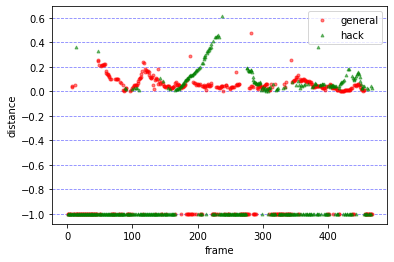

In [ ]:
#전체 프레임에 대해 비교. class 1에 대해서만
# 11 / 12 / 13 / 14 - feature_list
file = open('/content/drive/Shareddrives/블루스크린_졸업작품/feature_list/general/output2.txt', 'rt')
file2 = open('/content/drive/Shareddrives/블루스크린_졸업작품/feature_list/hack/output2.txt', 'rt')

num = 1 #0,1,2 / 1 - roadhog

read_data = file.readlines()
read_data2 = file2.readlines()
d_list = read_data[num].split(' ')
d_list2 = read_data2[num].split(' ')
print(d_list)
print(d_list2)
length = int(len(d_list) - 1)
length2 = int(len(d_list2) - 1)
print(length)
print(length2)
f_length = 0
if length < length2:
  f_length = length
else:
  f_length = length2
frame = np.arange(1, f_length+1, 1)
dg, dh = [], []
for i in range(f_length):
    dg.append(float(d_list[i]))
    dh.append(float(d_list2[i]))

df = pd.DataFrame({"frame":frame, "dist_gen":dg, "dist_hack":dh})
# df = df.replace({-1:np.nan})
display(df)

plt.plot(df['frame'], df['dist_gen'], color='r', markersize=3, marker = 'o', alpha=0.5, label='general', linestyle='')
plt.plot(df['frame'], df['dist_hack'], color='g', markersize=3, marker = '^', alpha=0.5, label='hack', linestyle='')
plt.grid(True, axis='y', color='blue', alpha=0.5, linestyle='--')
plt.xlabel('frame')
plt.ylabel('distance')
# plt.ylim([0.0, 0.4])
# plt.title('roadhog')
# plt.yticks([-1.0, 0, 0.2, 0.4, 0.6, 0.8])
plt.legend(loc='upper right')
#plt.show()
plt.savefig('/content/savefig_200dpi.png', dpi=200)

file.close()
file2.close()

['-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.10730402415566714', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.5266086404190496', '-1', '0.49364530230622067', '-1', '0.5101370846517629', '-1', '-1', '0.5649967636836515', '-1', '0.462090734020928', '0.5077030817564534', '0.5112489248546153', '0.4976185576623926', '0.5007510422685109', '0.497817901301269', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.3145394564311448', '-1', '-1', '0.49133652746869944', '-1', '-1', '0.408406814659954', '0.39963552816034764', '0.3868610992139168', '0.37708277017784836', '0.3678849525721323', '0.35797770868169987', '0.26851030390657266', '0.13355369096359712', '0.05528347431194969', '0.199119537275979', '0.27148898167329', '0.27453615419649197', '0.275927699879878', '0.27614593333960213', '0.2765012532991487', '0.27727427371647734', '0.27929199132091126', '0.2850160687978837', '0.29305599354730827', '-1', '-1', 

,frame,d0,d1,d2
0,1,-1.000000,-1.000000,-1.000000
1,2,-1.000000,-1.000000,-1.000000
2,3,-1.000000,-1.000000,-1.000000
3,4,-1.000000,-1.000000,-1.000000
4,5,-1.000000,-1.000000,-1.000000
...,...,...,...,...
458,459,0.026856,-1.000000,0.027335
459,460,0.027585,-1.000000,-1.000000
460,461,0.027013,-1.000000,0.026919
461,462,0.020420,-1.000000,0.021398


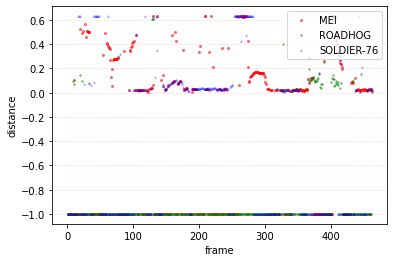

In [ ]:
#전체 프레임에 대해 비교. class 세개에 대해
file = open('/content/drive/Shareddrives/블루스크린_졸업작품/feature_list/hack/output9.txt', 'rt')
savename = "/content/drive/Shareddrives/블루스크린_졸업작품/graph/distance(for 1 frame  3 character)/hack/hack_200dpi_distance_9"

classList = [0, 1, 2] #0,1,2 / 0 - mei, 1 - roadhog, 2 - soldier76

dummyList = []

read_data = file.readlines()
for i in classList:
  d_list = read_data[i].split(' ')
  dummyList.append(d_list)
  print(d_list)

length = int(len(dummyList[0]) - 1)
print(length)

frame = np.arange(1, length+1, 1)

d0, d1, d2 = [], [], []

for i in range(length):
    d0.append(float(dummyList[0][i]))
    d1.append(float(dummyList[1][i]))
    d2.append(float(dummyList[2][i]))


df = pd.DataFrame({"frame" : frame, "d0" : d0, "d1" : d1, "d2" : d2})
# df = df.replace({-1:np.nan})
display(df)

plt.plot(df['frame'], df['d0'], color='r', markersize=2, marker = 'o', alpha=0.5, label='MEI', linestyle='')
plt.plot(df['frame'], df['d1'], color='g', markersize=2, marker = '*', alpha=0.4, label='ROADHOG', linestyle='')
plt.plot(df['frame'], df['d2'], color='b', markersize=2, marker = '^', alpha=0.2, label='SOLDIER-76', linestyle='')
plt.grid(True, axis='y', color='pink', alpha=0.5, linestyle='--')
plt.xlabel('frame')
plt.ylabel('distance')
# plt.ylim([0.0, 0.4])
# plt.title('roadhog')
# plt.yticks([-1.0, 0, 0.2, 0.4, 0.6, 0.8])
plt.legend(loc='upper right')

plt.savefig(savename, dpi=200)

file.close()

,step,sub_g,sub_h
0,1,NaN,NaN
1,2,NaN,NaN
2,3,NaN,NaN
3,4,NaN,NaN
4,5,NaN,NaN
...,...,...,...
461,462,NaN,NaN
462,463,NaN,NaN
463,464,NaN,NaN
464,465,NaN,0.039738


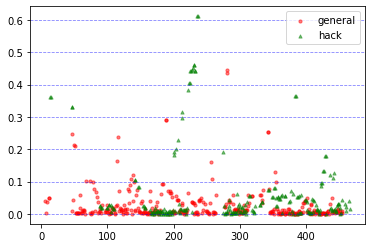

In [ ]:
# 거리의 차 그래프 그리기 코드
# print(d_list)
# print(d_list2)

sub_g = list()
sub_h = list()

for i in range(len(d_list) - 2): # 배열에 \n 포함, 따라서 2를 빼 주어야 함
  result_g = abs(float(d_list[i+1]) - float(d_list[i]))
  # 1이 넘는 값들은 갑자기 등장한 값. 1 빼주기?
  if result_g > 1:
    result_g = result_g - 1
  sub_g.append(result_g)

for i in range(len(d_list2) - 2):
  result_h = abs(float(d_list2[i+1]) - float(d_list2[i]))
  if result_h > 1:
    result_h = result_h - 1
  sub_h.append(result_h)


step_len = len(sub_g) if len(sub_g) < len(sub_h) else len(sub_h)
step = np.arange(1, step_len+1, 1)

sub = pd.DataFrame({"step":step, "sub_g":sub_g[:step_len], "sub_h":sub_h[:step_len]})
sub = sub.replace({0:np.nan})
display(sub)

# 0.0 인 값들은 -1과 -1의 차일때, 또는 두 프레임 간 거리값이 완전히 똑같을 때(전자가 전부라고 볼 수 있음)
# 1이 넘는 값들은 검출되지 않다가 갑자기 검출될 때의 값들
# 0과 1 사이의 값들이 제대로 검출될 때의 차 값


plt.scatter(sub['step'], sub['sub_g'], color='r', s=10, alpha=0.5, label='general')
plt.scatter(sub['step'], sub['sub_h'], color='g', s=10, marker = '^', alpha=0.5, label='hack')
plt.grid(True, axis='y', color='blue', alpha=0.5, linestyle='--')
# plt.plot(sub['step'], sub['sub_g'], 'rs--', label='general')
# plt.plot(sub['step'], sub['sub_h'], 'bo--', label='hack')
plt.legend(loc='upper right')
plt.savefig('/content/savefig_200dpi_sub.png', dpi=200)


In [ ]:
#전체 프레임에 대해 비교. class 세개에 대해
file = open('/content/drive/Shareddrives/블루스크린_졸업작품/feature_list/general/output9.txt', 'rt')
savename = '/content/drive/Shareddrives/블루스크린_졸업작품/graph/general_200dpi_9.png'

classList = [0, 1, 2] #0,1,2 / 0 - mei, 1 - roadhog, 2 - soldier76

dummyList = []

read_data = file.readlines()
for i in classList:
  d_list = read_data[i].split(' ')
  dummyList.append(d_list)
  print(d_list)

length = int(len(dummyList[0]) - 1)
print(length)

# frame = np.arange(1, length+1, 1)

d0, d1, d2 = [], [], []

for i in range(length):
    d0.append(float(dummyList[0][i]))
    d1.append(float(dummyList[1][i]))
    d2.append(float(dummyList[2][i]))

ds0, ds1, ds2 = [], [], []

for i in range(length - 1):
  result = abs(float(d0[i+1]) - float(d0[i]))
  if result > 1:
    result = result - 1
  ds0.append(result)

for i in range(length - 1):
  result = abs(float(d1[i+1]) - float(d1[i]))
  if result > 1:
    result = result - 1
  ds1.append(result)

for i in range(length - 1):
  result = abs(float(d2[i+1]) - float(d2[i]))
  if result > 1:
    result = result - 1
  ds2.append(result)

step = np.arange(1, length, 1)
print(len(step))

df = pd.DataFrame({"step" : step, "ds0" : ds0, "ds1" : ds1, "ds2" : ds2})
df = df.replace({0:np.nan})
display(df)

plt.plot(df['step'], df['ds0'], color='r', markersize=3, marker = 'o', alpha=0.5, label='MEI', linestyle='')
plt.plot(df['step'], df['ds1'], color='g', markersize=3, marker = '*', alpha=0.7, label='ROADHOG', linestyle='')
plt.plot(df['step'], df['ds2'], color='b', markersize=3, marker = '^', alpha=0.3, label='SOLDIER-76', linestyle='')
plt.grid(True, axis='y', color='pink', alpha=0.5, linestyle='--')
plt.xlabel('step')
plt.ylabel('distance of distance')
# plt.ylim([0.0, 0.4])
# plt.title('roadhog')
# plt.yticks([-1.0, 0, 0.2, 0.4, 0.6, 0.8])
plt.legend(loc='upper right')

plt.savefig(savename, dpi=200)

file.close()

#### 그래프 테스트 코드

['-1', '-1', '-1', '-1', '-1', '-1', '0.040991512353168946', '0.037543276162316994', '-1', '-1', '-1', '0.047828791015454335', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.24642976413168927', '0.2566836881708691', '0.2124044209167973', '-1', '-1', '0.20861529112219937', '0.21097457110277526', '0.2123807428558437', '0.21476836690723336', '0.21729530953290274', '0.21909791440814771', '0.22217767282965228', '0.1633246094040944', '0.1462652127506742', '0.14455023391541083', '0.14229960846397288', '0.13393708748886549', '0.12089192266235156', '0.11283987604122929', '0.10111245640374876', '0.10230690694180913', '-1', '-1', '-1', '-1', '-1', '-1', '0.10184019350433304', '0.09834001692596962', '0.09847767193125556', '0.10367281938869032', '0.09947092834592422', '-1', '-1', '0.07798062740193872', '0.06924050624453867', '-1', '-1', '0.0

,frame,dist_gen,dist_hack
0,1.0,NaN,NaN
1,2.0,NaN,NaN
2,3.0,NaN,NaN
3,4.0,0.040992,NaN
4,5.0,NaN,NaN
...,...,...,...
229,230.0,NaN,NaN
230,231.0,NaN,0.020579
231,232.0,NaN,NaN
232,233.0,NaN,NaN


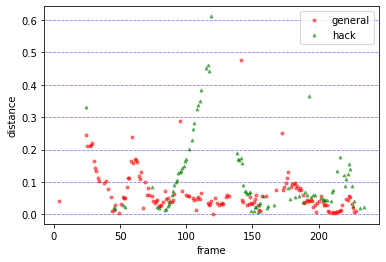

In [ ]:
#전체 프레임에 대해 비교. class 1에 대해서만 / 2프레임마다
# 11 / 12 / 13 / 14 - feature_list
file = open('/content/drive/Shareddrives/블루스크린_졸업작품/feature_list/general/output2.txt', 'rt')
file2 = open('/content/drive/Shareddrives/블루스크린_졸업작품/feature_list/hack/output2.txt', 'rt')

num = 1 #0,1,2 / 1 - roadhog

read_data = file.readlines()
read_data2 = file2.readlines()
d_list = read_data[num].split(' ')
d_list2 = read_data2[num].split(' ')
print(d_list)
print(d_list2)
length = int(len(d_list) - 1)
length2 = int(len(d_list2) - 1)
print(length)
print(length2)
f_length = 0
if length < length2:
  f_length = length
else:
  f_length = length2
frame = np.arange(1, (f_length/2)+1, 1) # 몇 프레임마다 출력할지로 나눔
dg, dh = [], []
for i in range(0, f_length, 2): # 프레임 개수만큼 증가
    dg.append(float(d_list[i]))
    dh.append(float(d_list2[i]))

df = pd.DataFrame({"frame":frame, "dist_gen":dg, "dist_hack":dh})
df = df.replace({-1:np.nan})
display(df)

plt.plot(df['frame'], df['dist_gen'], color='r', markersize=3, marker = 'o', alpha=0.5, label='general', linestyle='')
plt.plot(df['frame'], df['dist_hack'], color='g', markersize=3, marker = '^', alpha=0.5, label='hack', linestyle='')
plt.grid(True, axis='y', color='blue', alpha=0.5, linestyle='--')
plt.xlabel('frame')
plt.ylabel('distance')
# plt.ylim([0.0, 0.7])
# plt.title('roadhog')
# plt.yticks([-1.0, 0, 0.2, 0.4, 0.6, 0.8])
plt.legend(loc='upper right')
#plt.show()
plt.savefig('/content/savefig_200dpi_dist_per2.png', dpi=200)

file.close()
file2.close()

['-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.10730402415566714', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.5266086404190496', '-1', '0.49364530230622067', '-1', '0.5101370846517629', '-1', '-1', '0.5649967636836515', '-1', '0.462090734020928', '0.5077030817564534', '0.5112489248546153', '0.4976185576623926', '0.5007510422685109', '0.497817901301269', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.3145394564311448', '-1', '-1', '0.49133652746869944', '-1', '-1', '0.408406814659954', '0.39963552816034764', '0.3868610992139168', '0.37708277017784836', '0.3678849525721323', '0.35797770868169987', '0.26851030390657266', '0.13355369096359712', '0.05528347431194969', '0.199119537275979', '0.27148898167329', '0.27453615419649197', '0.275927699879878', '0.27614593333960213', '0.2765012532991487', '0.27727427371647734', '0.27929199132091126', '0.2850160687978837', '0.29305599354730827', '-1', '-1', 

,frame,d0,d1,d2
0,1.0,-1.000000,-1.000000,-1.000000
1,2.0,-1.000000,-1.000000,-1.000000
2,3.0,-1.000000,-1.000000,-1.000000
3,4.0,-1.000000,-1.000000,-1.000000
4,5.0,-1.000000,0.096663,-1.000000
...,...,...,...,...
227,228.0,0.015612,-1.000000,-1.000000
228,229.0,0.019050,-1.000000,0.026570
229,230.0,0.026856,-1.000000,0.027335
230,231.0,0.027013,-1.000000,0.026919


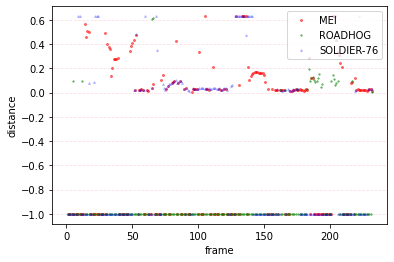

In [ ]:
#전체 프레임에 대해 비교. class 세개 전부 / 2프레임마다
file = open('/content/drive/Shareddrives/블루스크린_졸업작품/feature_list/hack/output9.txt', 'rt')
savename = "/content/test"
# savename = "/content/drive/Shareddrives/블루스크린_졸업작품/graph/distance(for 1 frame  3 character)/hack/hack_200dpi_distance_9"

classList = [0, 1, 2] #0,1,2 / 0 - mei, 1 - roadhog, 2 - soldier76

dummyList = []

read_data = file.readlines()
for i in classList:
  d_list = read_data[i].split(' ')
  dummyList.append(d_list)
  print(d_list)

length = int(len(dummyList[0]) - 1)
print(length)

frame = np.arange(1, (length/2)+1, 1)

d0, d1, d2 = [], [], []

for i in range(0, length, 2):
    d0.append(float(dummyList[0][i]))
    d1.append(float(dummyList[1][i]))
    d2.append(float(dummyList[2][i]))


df = pd.DataFrame({"frame" : frame, "d0" : d0, "d1" : d1, "d2" : d2})
# df = df.replace({-1:np.nan})
display(df)

plt.plot(df['frame'], df['d0'], color='r', markersize=2, marker = 'o', alpha=0.5, label='MEI', linestyle='')
plt.plot(df['frame'], df['d1'], color='g', markersize=2, marker = '*', alpha=0.4, label='ROADHOG', linestyle='')
plt.plot(df['frame'], df['d2'], color='b', markersize=2, marker = '^', alpha=0.2, label='SOLDIER-76', linestyle='')
plt.grid(True, axis='y', color='pink', alpha=0.5, linestyle='--')
plt.xlabel('frame')
plt.ylabel('distance')
# plt.ylim([0.0, 0.4])
# plt.title('roadhog')
# plt.yticks([-1.0, 0, 0.2, 0.4, 0.6, 0.8])
plt.legend(loc='upper right')

plt.savefig(savename, dpi=200)

file.close()

['-1', '-1', '-1', '-1', '-1', '0.10706221942870417', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.4561327686227004', '-1', '-1', '-1', '-1', '-1', '-1', '0.20335734365151412', '0.25809997879310254', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.3208313953730214', '0.49360620515143444', '-1', '-1', '-1', '-1', '0.41597398045190276', '0.4027389437948607', '0.40108821874620054', '0.39608702350493635', '-1', '-1', '0.4828395870897498', '0.5032663158298994', '0.5031633763639798', '0.5017748815006586', '0.5074623460947619', '0.5087656567350041', '0.5076867725881776', '0.03426864228416413', '0.04159542787374594', '0.04159542787374594', '0.15094414348692034', '0.15094414348692034', '0.16797495482958166', '0.16797495482958166', '0.1721370888100528', '0.19030385495044497', '0.19030385495044497', '0.21703684939198686', '0.312560503584506', '0.3100260208127698', '0.3198562287043977', '0.3551122735994913', '0.3551122735994913', '0.36513161

,step,ds0,ds1,ds2
0,1,NaN,0.007733,NaN
1,4,NaN,0.019784,NaN
2,7,NaN,0.009627,NaN
3,10,NaN,0.002580,NaN
4,13,NaN,0.001535,NaN
...,...,...,...,...
149,448,NaN,NaN,NaN
150,451,NaN,NaN,NaN
151,454,NaN,NaN,NaN
152,457,NaN,NaN,NaN


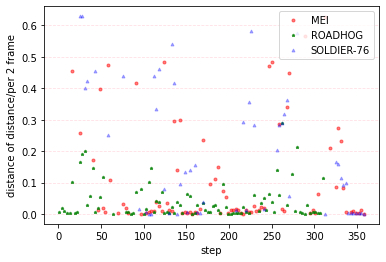

In [ ]:
#전체 프레임에 대해 비교/거리의 차. class 세개에 대해 /per n frame
n = 3

videoType = 'general'
fileNum = 10

file = open('/content/drive/Shareddrives/블루스크린_졸업작품/feature_list/{}/output{}.txt'.format(videoType,fileNum), 'rt')
savename = '/content/drive/Shareddrives/블루스크린_졸업작품/graph/distance of distance/{}/{}/{}_200dpi_per{}frame_{}.png'.format('for 3 frame', videoType, videoType, 3, fileNum)

classList = [0, 1, 2] #0,1,2 / 0 - mei, 1 - roadhog, 2 - soldier76

dummyList = []

read_data = file.readlines()
for i in classList:
  d_list = read_data[i].split(' ')
  dummyList.append(d_list)
  print(d_list)

length = int(len(dummyList[0]) - 1)
print(length)

# frame = np.arange(1, length+1, 1)

d0, d1, d2 = [], [], []

for i in range(length):
    d0.append(float(dummyList[0][i]))
    d1.append(float(dummyList[1][i]))
    d2.append(float(dummyList[2][i]))

ds0, ds1, ds2 = [], [], []

for i in range(0, length - 1, n):
  result = abs(float(d0[i+1]) - float(d0[i]))
  if result > 1:
    result = result - 1
  ds0.append(result)

for i in range(0, length - 1, n):
  result = abs(float(d1[i+1]) - float(d1[i]))
  if result > 1:
    result = result - 1
  ds1.append(result)

for i in range(0, length - 1, n):
  result = abs(float(d2[i+1]) - float(d2[i]))
  if result > 1:
    result = result - 1
  ds2.append(result)

step = np.arange(1, length , n)

print(len(step))
print(len(ds1))

df = pd.DataFrame({"step" : step, "ds0" : ds0, "ds1" : ds1, "ds2" : ds2})
df = df.replace({0:np.nan})
display(df)

plt.plot(df['step'], df['ds0'], color='r', markersize=3, marker = 'o', alpha=0.5, label='MEI', linestyle='')
plt.plot(df['step'], df['ds1'], color='g', markersize=3, marker = '*', alpha=0.7, label='ROADHOG', linestyle='')
plt.plot(df['step'], df['ds2'], color='b', markersize=3, marker = '^', alpha=0.3, label='SOLDIER-76', linestyle='')
plt.grid(True, axis='y', color='pink', alpha=0.5, linestyle='--')
plt.xlabel('step')
plt.ylabel('distance of distance/per 2 frame')
# plt.ylim([0.0, 0.4])
# plt.title('roadhog')
# plt.yticks([-1.0, 0, 0.2, 0.4, 0.6, 0.8])
plt.legend(loc='upper right')

plt.savefig(savename, dpi=200)

file.close()

['0.022566778081950487', '0.030300108267133287', '0.05013881519342072', '0.07189864880510617', '0.09168233888814133', '0.10667157800464006', '0.09568402693239865', '0.0860569222143111', '0.06905320189535022', '0.050095973261331146', '0.052676256406468364', '0.1743286907998796', '0.17023398888001187', '0.1717692810370935', '0.15728232244597606', '0.07226819795733118', '0.17343519348736575', '-1', '0.19973663692472649', '0.19625260739159622', '0.2115040504813088', '0.21657526637407148', '0.22258178396715217', '0.1682349507860956', '0.16540243575292354', '-1', '-1', '-1', '0.1921795360203578', '0.18864291204813394', '-1', '0.19912354688735334', '0.21654917358420003', '0.2454766494251541', '0.27519571604405474', '0.28551519928893454', '0.30089715806069023', '0.24301843276796928', '0.1900769187723749', '0.14542928992812965', '-1', '0.09786399432375528', '0.10707124835827778', '0.11343217612741105', '0.14914414064253417', '0.14860483978659647', '0.16620450078141685', '-1', '0.171095232949372

,step,ds
0,1,0.007733
1,3,0.021760
2,5,0.014989
3,7,0.009627
4,9,0.018957
...,...,...
225,451,NaN
226,453,NaN
227,455,NaN
228,457,NaN


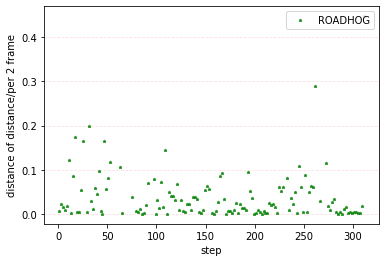

In [ ]:
#전체 프레임에 대해 비교/거리의 차. class 로드호그에 대해 /per n frame
n = 2

videoType = 'general'
graphName = 'general_Roadhog' #hack_Roadhog
fileNum = 10
forFrame = 'for 2 frame' # folder 생성 후 실행할 것

file = open('/content/drive/Shareddrives/블루스크린_졸업작품/feature_list/{}/output{}.txt'.format(videoType, fileNum), 'rt')
savename = '/content/drive/Shareddrives/블루스크린_졸업작품/graph/distance of distance/{}/{}/{}_200dpi_per{}frame_{}.png'.format(forFrame, videoType, graphName, n, fileNum)

classNum = 1 #0,1,2 / 0 - mei, 1 - roadhog, 2 - soldier76

read_data = file.readlines()
d_list = read_data[classNum].split(' ')
print(d_list)

length = int(len(d_list) - 1)
print(length)

d = []

for i in range(length):
    d.append(float(d_list[i]))

ds = []

for i in range(0, length - 1, n):
  result = abs(float(d[i+1]) - float(d[i]))
  if result > 1:
    result = result - 1
  ds.append(result)

step = np.arange(1, length , n)

print(len(step))
print(len(ds))

df = pd.DataFrame({"step" : step, "ds" : ds})
df = df.replace({0:np.nan})
display(df)

plt.plot(df['step'], df['ds'], color='g', markersize=3, marker = '*', alpha=0.7, label='ROADHOG', linestyle='')
plt.grid(True, axis='y', color='pink', alpha=0.5, linestyle='--')
plt.xlabel('step')
plt.ylabel('distance of distance/per {} frame'.format(n))
# plt.ylim([0.0, 0.4])
# plt.title('roadhog')
# plt.yticks([-1.0, 0, 0.2, 0.4, 0.6, 0.8])
plt.legend(loc='upper right')

plt.savefig(savename, dpi=200)

file.close()

### 분산 구하기

In [ ]:
import math
def get_var(hack, format):
  file = open('/content/drive/Shareddrives/블루스크린_졸업작품/test_result/%s/output{}.txt'.format(format) % hack, 'rt')

  read_data = file.readlines()
  d0_list = read_data[0].split(' ')
  d1_list = read_data[1].split(' ')
  d2_list = read_data[2].split(' ')
  del d0_list[-1]
  del d1_list[-1]
  del d2_list[-1]
  # print(d0_list)
  # print(d1_list)
  # print(d2_list)
  length = int(len(d0_list))
  # print(length)

  d0, d1, d2 = [], [], []
  for i in range(length):
      d0.append(float(d0_list[i]))

  for i in range(length):
      d1.append(float(d1_list[i]))

  for i in range(length):
      d2.append(float(d2_list[i]))

  file.close()

  d0 = list(filter(lambda x : x < 0.4 and x > 0.0, d0))
  d1 = list(filter(lambda x : x < 0.4 and x > 0.0, d1))
  d2 = list(filter(lambda x : x < 0.4 and x > 0.0, d2))
  
  # print(d0)
  # print(d1)
  # print(d2)
 
  num_var0 = np.var(d0)
  num_var1 = np.var(d1)
  num_var2 = np.var(d2)
  # print(num_var0, num_var1, num_var2)

  return num_var0, num_var1, num_var2

# vals = d0

# mean = sum(vals) / len(vals)
# print(mean)

# vsum = 0
# for val in vals:
#     vsum = vsum + (val - mean)**2
# variance = vsum / len(vals)
# print(variance)

In [ ]:
mei, roadhog, soldier76 = [], [], []
isHack = []
for i in range(1, 11, 1):
  vg0, vg1, vg2 = get_var('general', i)
  mei.append(vg0)
  roadhog.append(vg1)
  soldier76.append(vg2)
  isHack.append(0)
  vh0, vh1, vh2 = get_var('hack', i)
  mei.append(vh0)
  roadhog.append(vh1)
  soldier76.append(vh2)
  isHack.append(1)
  print('g{}: '.format(i), vg0, vg1, vg2)
  print('h{}: '.format(i), vh0, vh1, vh2)

g1:  0.015237333067112288 0.006530021011070664 0.005003725150816894
h1:  0.010893108601254258 0.008601318476197037 0.010881522590944938
g2:  0.013666816687587792 0.0027529580871106306 0.008366984290528427
h2:  0.008658147396760726 0.007922974967604192 0.009486023084371175
g3:  0.014950050879101662 0.002110670487777658 0.00833145112353078
h3:  0.005566278193166086 0.005798537498801989 0.00707762262729992
g4:  0.007880875092490929 0.01290792678800188 0.0024955064910628707
h4:  0.009871362604798688 0.004602441914016516 0.0050150717127695425
g5:  0.00833422802092535 0.0024127703185012213 0.007221795953570298
h5:  0.009266968659704018 0.003454632845215354 0.008831038855988047
g6:  0.01733322598337371 0.0032400943306068624 0.0044065612589821055
h6:  0.016623881559431862 0.0033263937591825592 0.012073176747545463
g7:  0.012446328872782901 0.002489284120067063 0.011860696548722257
h7:  0.0055512547861410995 0.007855471794653138 0.0042667721853070694
g8:  0.013236879790702408 0.0009104293978805

In [ ]:
print(len(mei), mei)
print(len(roadhog), roadhog)
print(len(soldier76), soldier76)
distance = mei + roadhog + soldier76
print(len(distance), distance)
print(len(isHack*3), isHack*3)
# mei.clear()
# roadhog.clear()
# soldier76.clear()
# isHack.clear()

20 [0.015237333067112288, 0.010893108601254258, 0.013666816687587792, 0.008658147396760726, 0.014950050879101662, 0.005566278193166086, 0.007880875092490929, 0.009871362604798688, 0.00833422802092535, 0.009266968659704018, 0.01733322598337371, 0.016623881559431862, 0.012446328872782901, 0.0055512547861410995, 0.013236879790702408, 0.014205674630573246, 0.010247673848874492, 0.012620898449799717, 0.010881220732914764, 0.016944072271646713]
20 [0.006530021011070664, 0.008601318476197037, 0.0027529580871106306, 0.007922974967604192, 0.002110670487777658, 0.005798537498801989, 0.01290792678800188, 0.004602441914016516, 0.0024127703185012213, 0.003454632845215354, 0.0032400943306068624, 0.0033263937591825592, 0.002489284120067063, 0.007855471794653138, 0.0009104293978805746, 0.0025307482824326087, 0.007803415795088689, 0.0023757778090567607, 0.004374242645924611, 0.002706032427449987]
20 [0.005003725150816894, 0.010881522590944938, 0.008366984290528427, 0.009486023084371175, 0.0083314511235

In [ ]:
import pandas as pd
 
df = pd.DataFrame() ## 1. 데이터 초기화
 
## 2. 만들고자 하는 열(Column)의 이름과 데이터를 이용하여 열 데이터 생성
df['distance'] = mei + roadhog + soldier76
df['isHack'] = isHack*3
df.to_csv('/content/drive/Shareddrives/블루스크린_졸업작품/test_result/variance_0.4.csv',index=False) #1,2,3,4

---

### 그래프 그리기/ 분산 데이터 구하기 등
- 테스트 코드 모음

In [ ]:
base_path = '/content/drive/Shareddrives/블루스크린_졸업작품/detection_result/'
output_path = '/content/drive/Shareddrives/블루스크린_졸업작품/feature_list/'
# %cd {output_path}
# %mkdir general
# %mkdir hack

/content/drive/Shareddrives/블루스크린_졸업작품/feature_list


In [ ]:
save_path = output_path + '/general'
for i in range(1, 11, 1):
  label_folder_path = base_path + 'general{}/labels'.format(i)
  video_file_path = base_path + 'general{}/일반{}.mp4'.format(i, i)
  feature(label_folder_path, video_file_path, save_path, i)

In [ ]:
save_path = output_path + '/hack'
for i in range(1, 11, 1):
  label_folder_path = base_path + 'hack{}/labels'.format(i)
  video_file_path = base_path + 'hack{}/핵{}.mp4'.format(i, i)
  feature(label_folder_path, video_file_path, save_path, i)

테스트중...

In [ ]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def serial_feature(label_folder_path, video_file_path, save_path, num):
  video = cv2.VideoCapture(video_file_path)

  if not video.isOpened():
      print("Could not Open :", video_file_path)
      exit(0)

  length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
  filename = os.path.basename(video_file_path[:-4])

  aim_pos = np.array((0.5, 0.5))
  cls, x, y, conf = 0, 0.0, 0.0, 0.0
  d0, d1, d2 = [], [], []
  feature = []

  for i in range(1, length + 1):
      label_file_path = label_folder_path + '/' + filename + '_' + str(i) + '.txt'
      print(label_file_path)
      try:
         file = open(label_file_path, 'rt')
      except FileNotFoundError:
          d0.append(-1), d1.append(-1), d2.append(-1)
          continue
      else:
          line = file.readlines()
          d0_obj, d1_obj, d2_obj = -1, -1, -1
          conf0, conf1, conf2 = 0, 0, 0
          for string in line:
              label_list = string.split(' ')
              cls = int(label_list[0])
              x, y = float(label_list[1]), float(label_list[2])
              conf = float(label_list[-1].rstrip())
              obj_pos = np.array((x, y))
              dist = np.sqrt(np.sum(np.square(aim_pos - obj_pos)))
              if cls == 0 and conf > conf0:
                  conf0 = conf
                  d0_obj = dist
              elif cls == 1 and conf > conf1:
                  conf1 = conf
                  d1_obj = dist
              elif cls == 2 and conf > conf2:
                  conf2 = conf
                  d2_obj = dist
          d0.append(d0_obj), d1.append(d1_obj), d2.append(d2_obj)
  
  data, i = [], 0
  with open(save_path + '/output{}.txt'.format(num), 'a') as f:
    for n in range(length):
      f.write(str(d0[n]) + ' ')
    f.write('\n')
    for n in range(length):
      f.write(str(d1[n]) + ' ')
    f.write('\n')
    for n in range(length):
      f.write(str(d2[n]) + ' ')
    f.write('\n')

In [ ]:
def feature(label_folder_path, video_file_path, save_path, num):
  video = cv2.VideoCapture(video_file_path)

  if not video.isOpened():
      print("Could not Open :", video_file_path)
      exit(0)

  length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
  filename = os.path.basename(video_file_path[:-4])

  aim_pos = np.array((0.5, 0.5))
  cls, x, y, conf = 0, 0.0, 0.0, 0.0
  d0, d1, d2 = [], [], []
  feature = []

  for i in range(1, length + 1):
      label_file_path = label_folder_path + '/' + filename + '_' + str(i) + '.txt'
      try:
         file = open(label_file_path, 'rt')
      except FileNotFoundError:
          d0.append(-1), d1.append(-1), d2.append(-1)
          continue
      else:
          line = file.readlines()
          d0_obj, d1_obj, d2_obj = -1, -1, -1
          conf0, conf1, conf2 = 0, 0, 0
          for string in line:
              label_list = string.split(' ')
              cls = int(label_list[0])
              x, y = float(label_list[1]), float(label_list[2])
              conf = float(label_list[-1].rstrip())
              obj_pos = np.array((x, y))
              dist = np.sqrt(np.sum(np.square(aim_pos - obj_pos)))
              if cls == 0 and conf > conf0:
                  conf0 = conf
                  d0_obj = dist
              elif cls == 1 and conf > conf1:
                  conf1 = conf
                  d1_obj = dist
              elif cls == 2 and conf > conf2:
                  conf2 = conf
                  d2_obj = dist
          d0.append(d0_obj), d1.append(d1_obj), d2.append(d2_obj)

  data, i = [], 0
  with open(save_path + '/output{}.txt'.format(num), 'a') as f:
      for m in range(i, length, 10):
          try:
              for n in range(m, m+10):
                  f.write(str(d0[n]) + ' ')
              for n in range(m, m+10):
                  f.write(str(d1[n]) + ' ')
              for n in range(m, m+10):
                  f.write(str(d2[n]) + ' ')
              # print(len(data), data)
              f.write('\n')
              data.clear()
          except IndexError:
              data = data + d0[m:-1] + d1[m:-1] + d2[m:-1]
              # print(len(data), data)
              for n in range(0, len(data)):
                  f.write(str(data[n]) + ' ')
              f.write('\n')
              break

In [ ]:
base_path = '/content/drive/Shareddrives/블루스크린_졸업작품/detection_result/'
output_path = '/content/drive/Shareddrives/블루스크린_졸업작품/test_result/'

save_path = output_path + 'hack'
for i in range(1, 11, 1):
  label_folder_path = base_path + 'hack{}/labels'.format(i)
  video_file_path = base_path + 'hack{}/핵{}.mp4'.format(i, i)
  serial_feature(label_folder_path, video_file_path, save_path, i)

In [ ]:
save_path = output_path + 'general'
for i in range(1, 11, 1):
  label_folder_path = base_path + 'general{}/labels'.format(i)
  video_file_path = base_path + 'general{}/일반{}.mp4'.format(i, i)
  serial_feature(label_folder_path, video_file_path, save_path, i)

In [ ]:
def draw_plot(output_file_path):
  file = open(output_file_path, 'rt')
  read_data = file.readlines()
  count = 0
  for text in read_data:
    count = count + 1
    d_list = text.split(' ')
    length = int((len(d_list) - 1) / 3)
    frame = np.arange(1, length + 1, 1)
    d0, d1, d2 = [], [], []
    for i in range(len(d_list) - 1):
      if i < length:
        d0.append(float(d_list[i]))
      elif i < 2 * length:
        d1.append(float(d_list[i]))
      elif i < 3 * length:
        d2.append(float(d_list[i]))
    plt.figure(count)
    plt.title(count)
    plt.plot(frame, d0, 'r', frame, d1, 'b', frame, d2, 'g')
    plt.xlabel('frame')
    plt.ylabel('distance')
    plt.show()

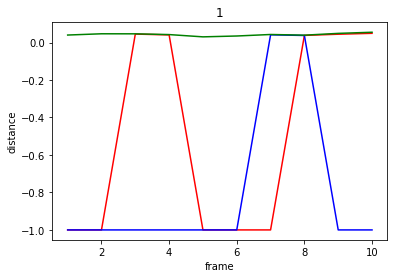

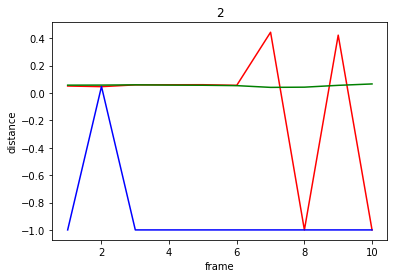

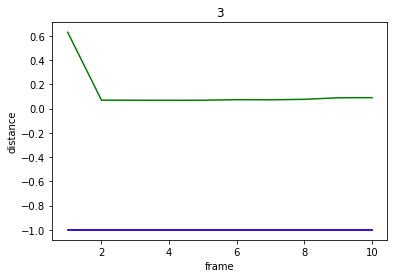

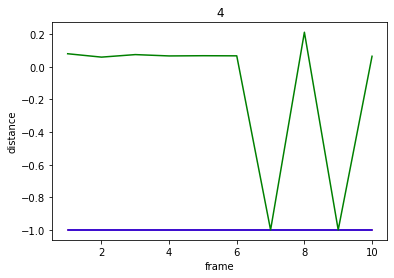

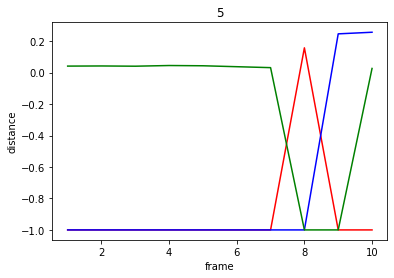

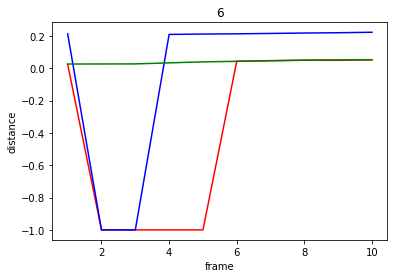

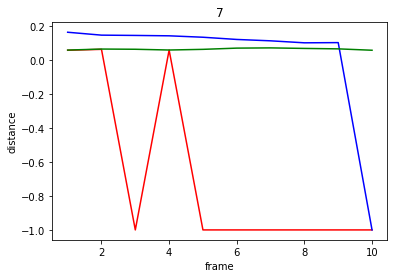

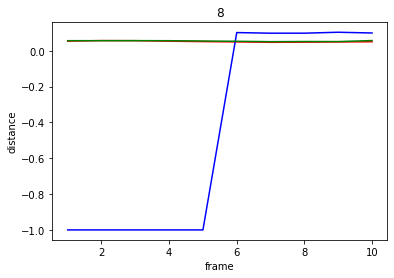

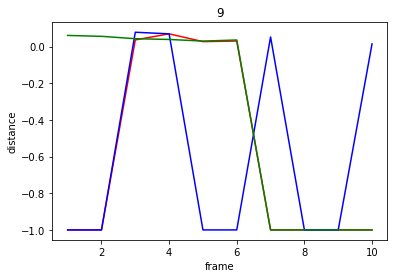

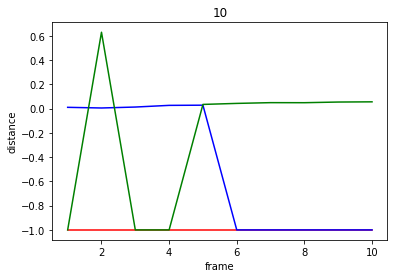

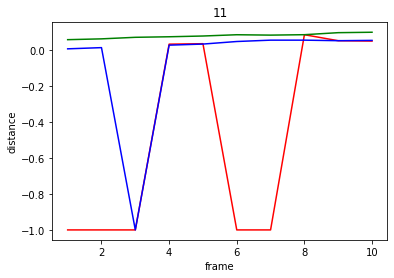

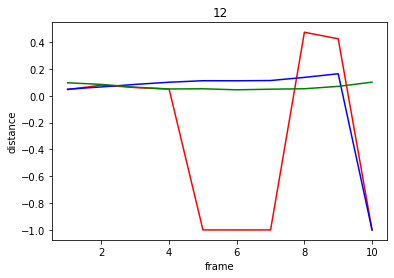

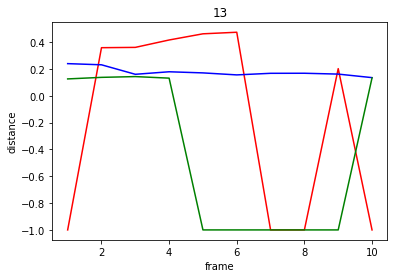

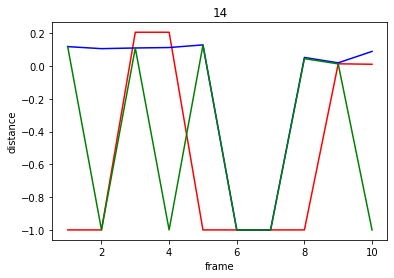

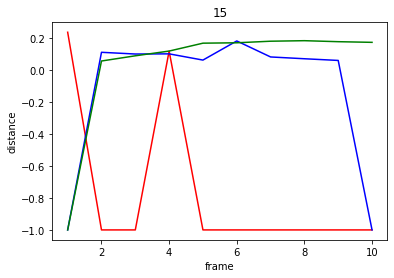

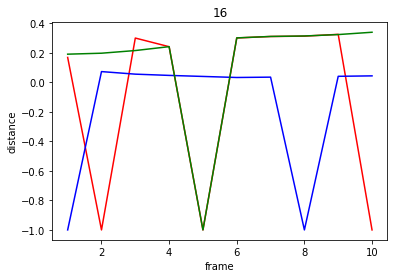

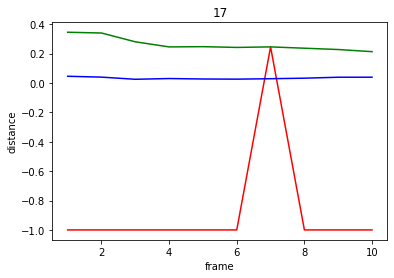

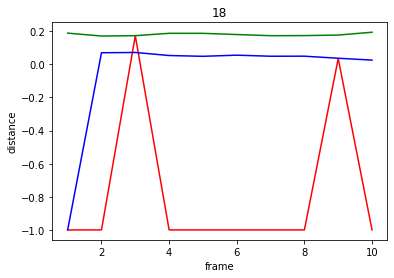

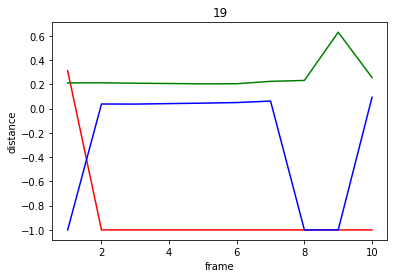

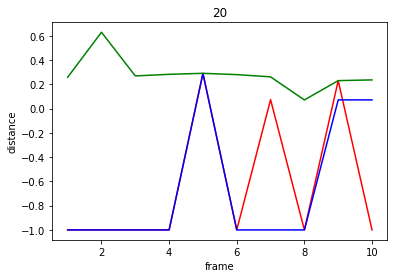

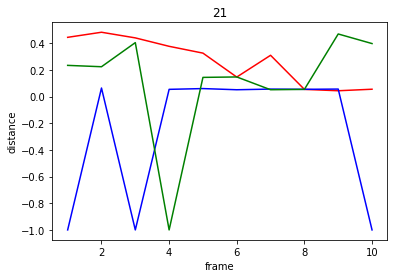

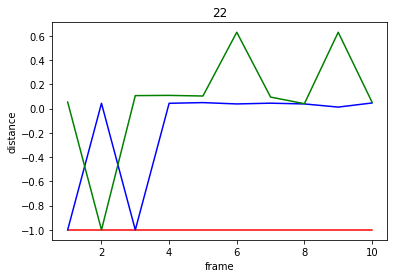

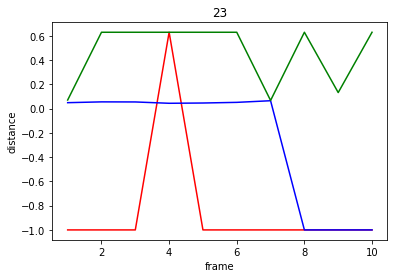

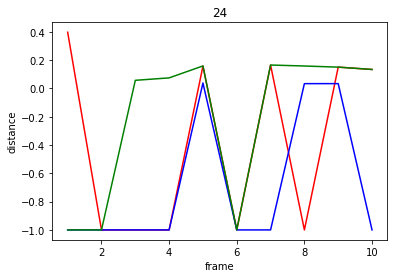

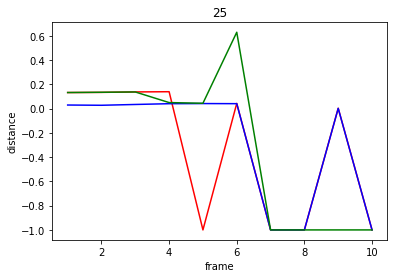

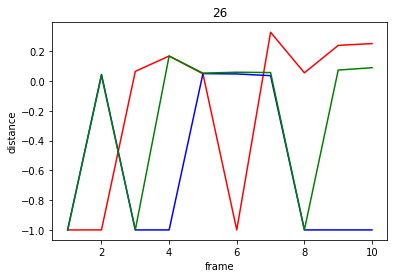

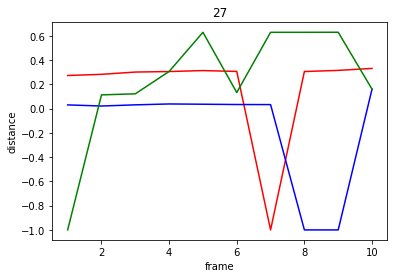

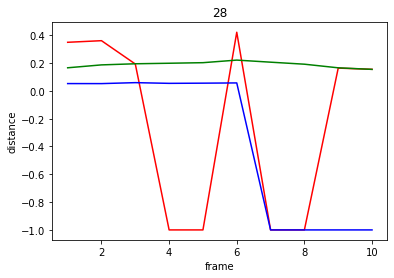

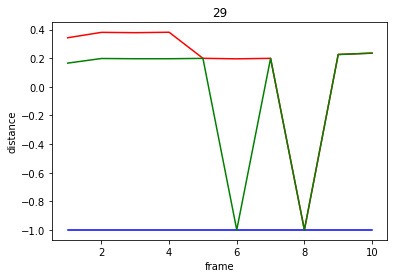

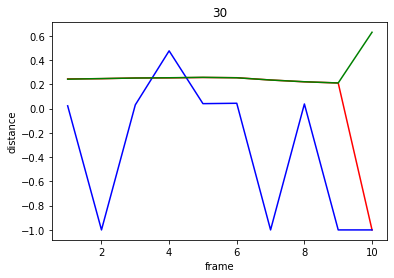

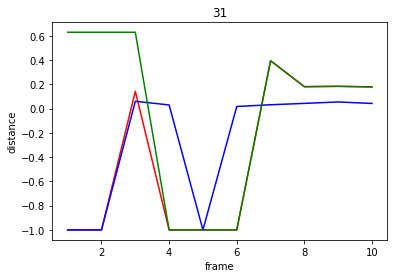

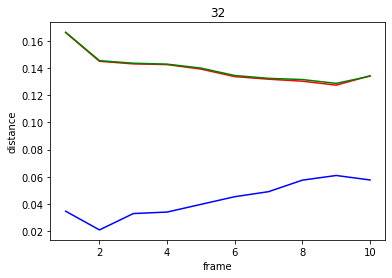

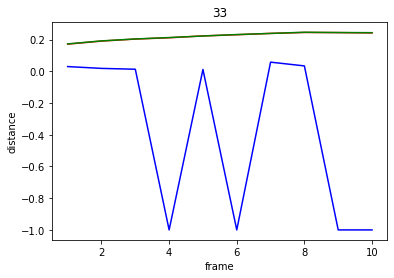

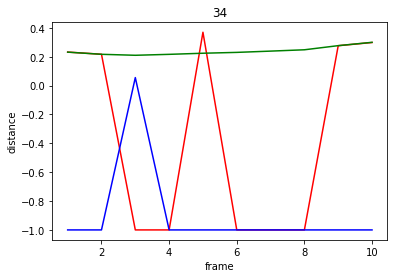

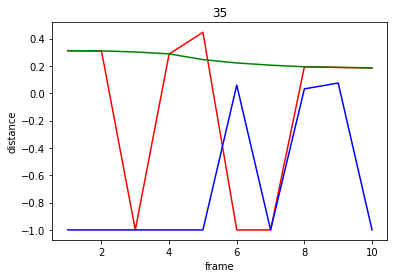

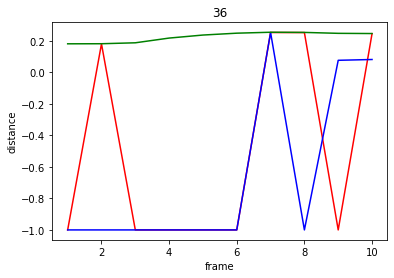

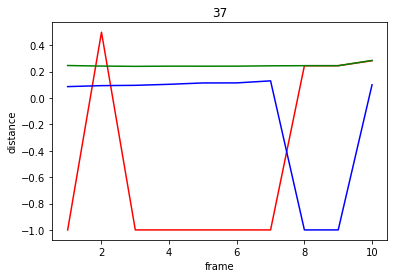

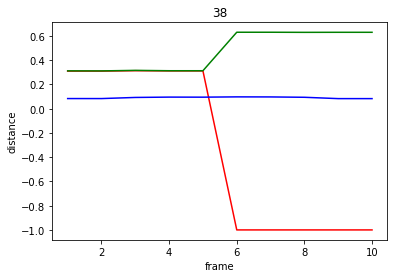

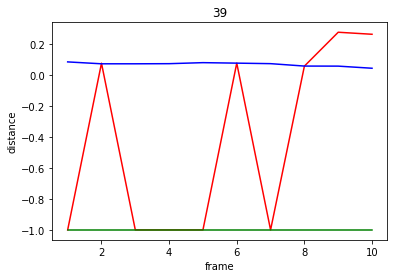

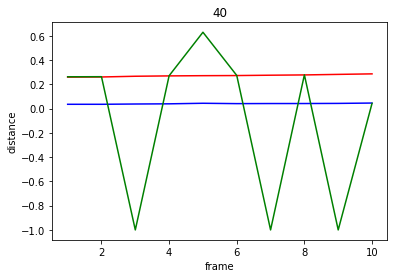

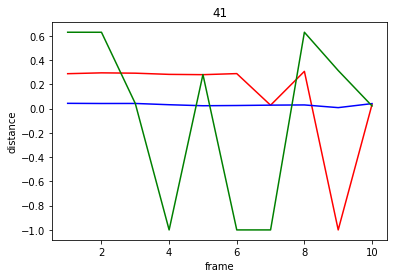

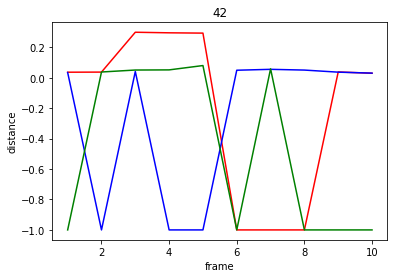

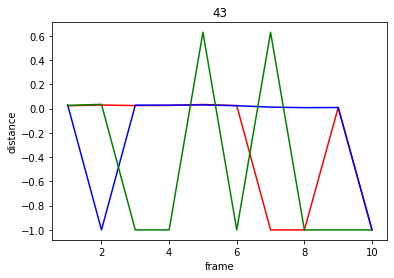

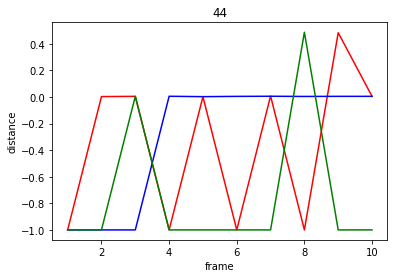

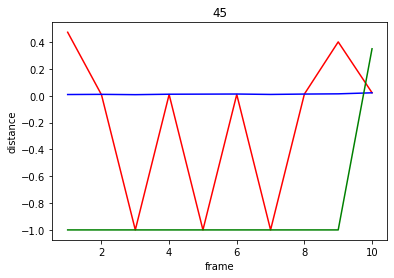

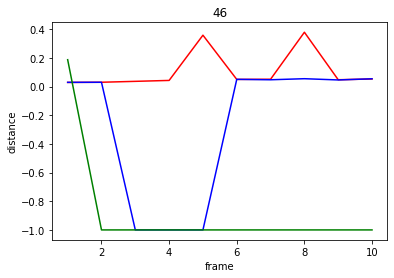

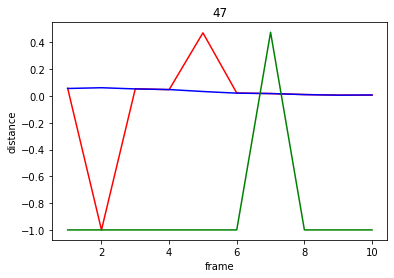

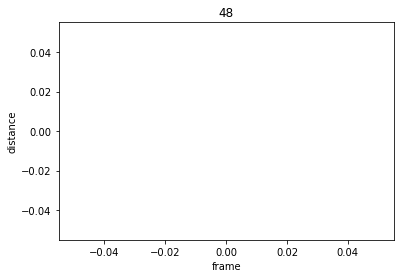

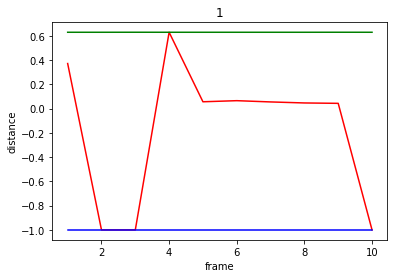

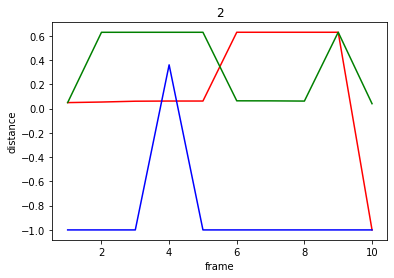

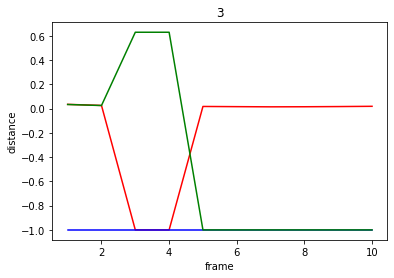

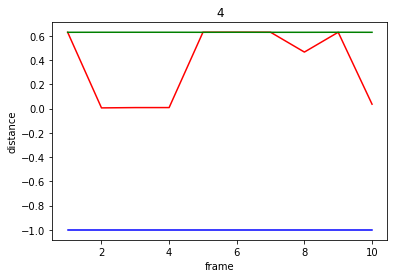

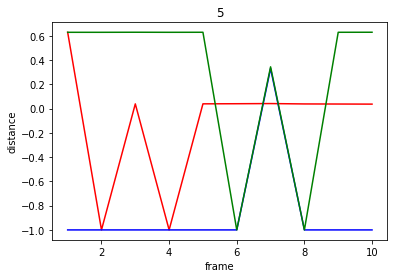

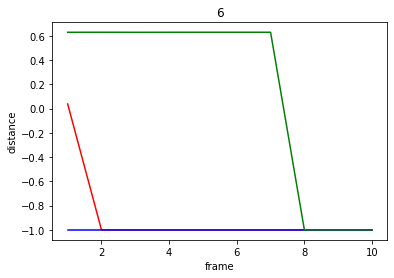

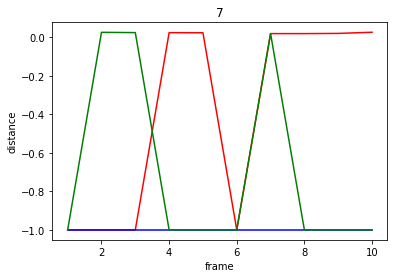

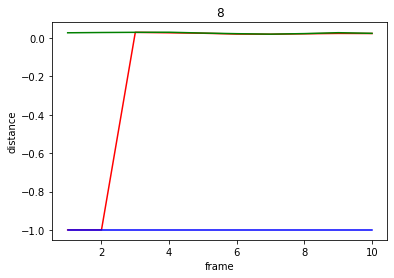

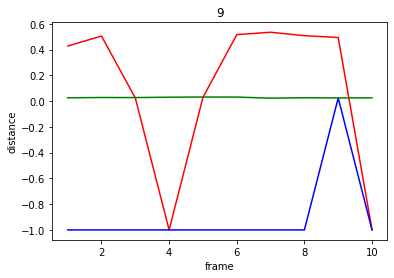

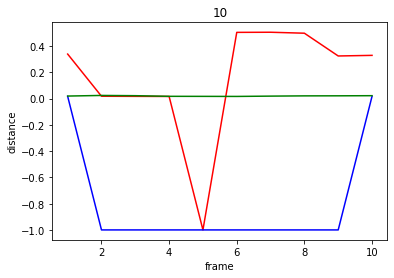

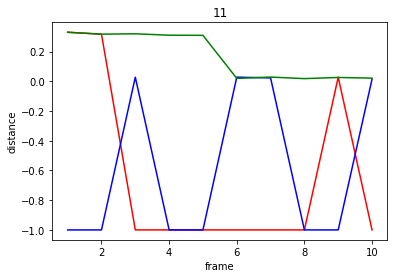

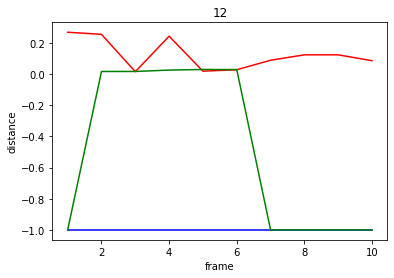

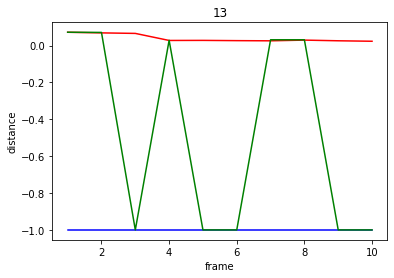

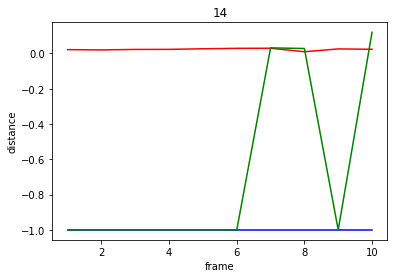

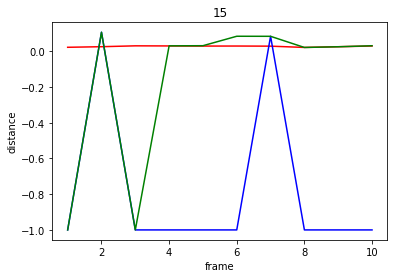

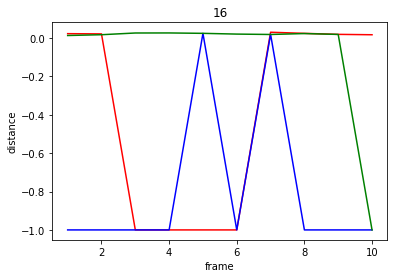

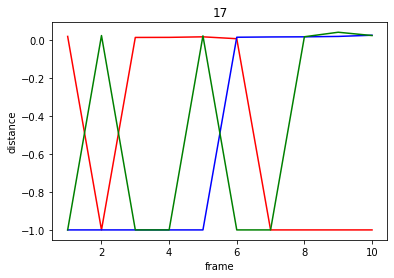

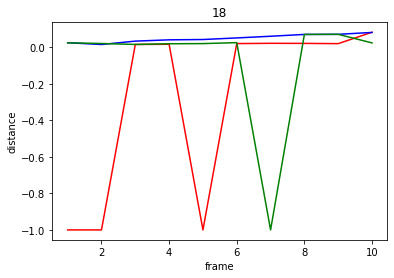

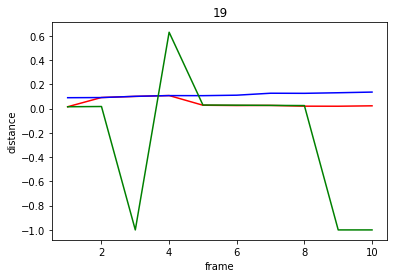

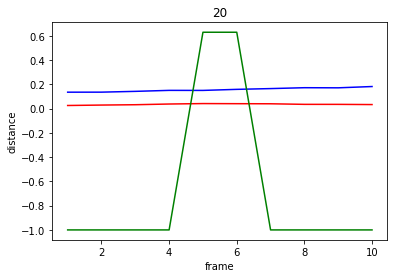

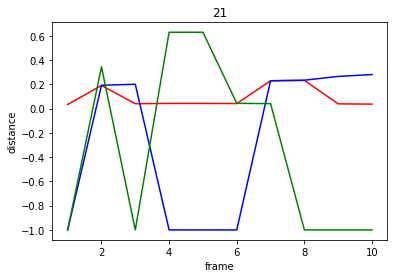

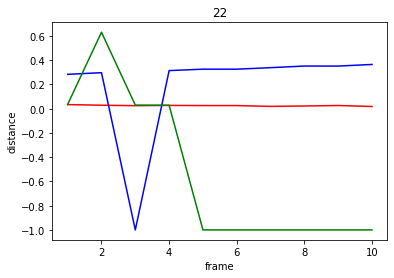

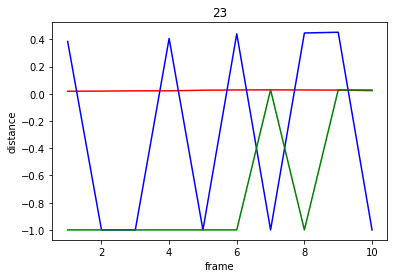

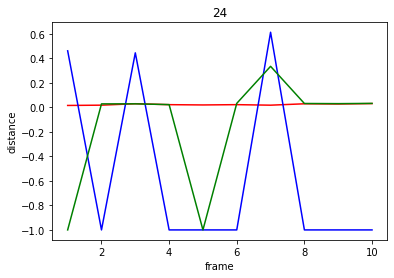

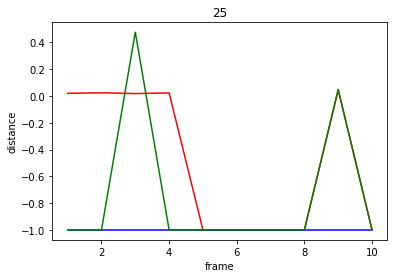

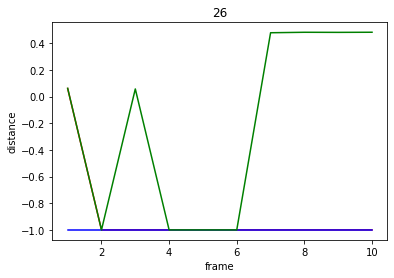

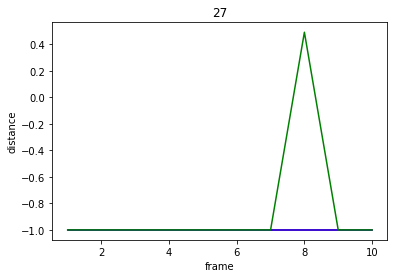

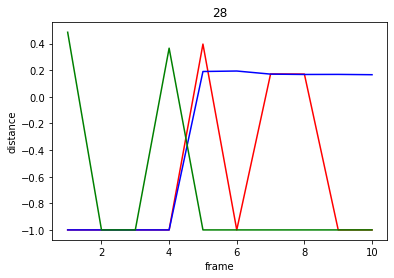

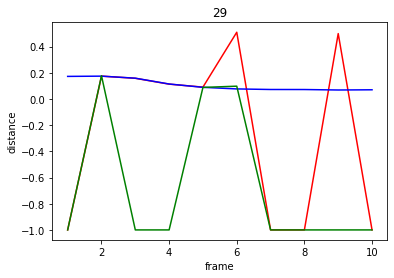

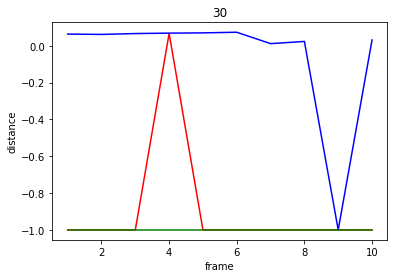

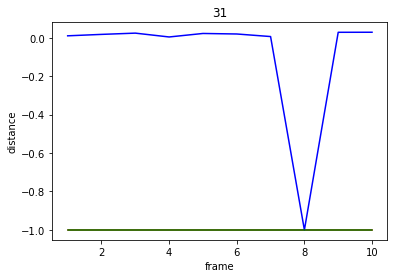

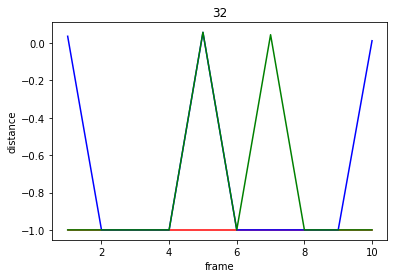

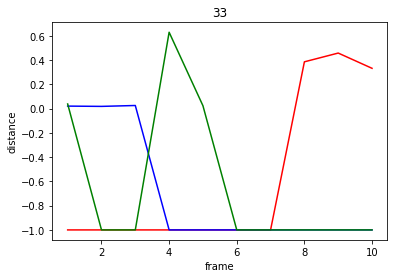

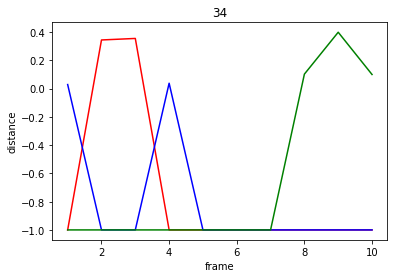

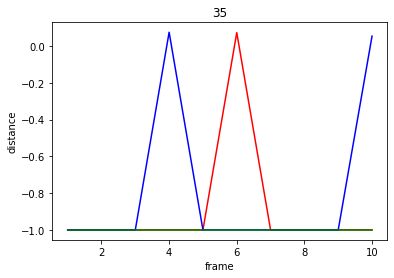

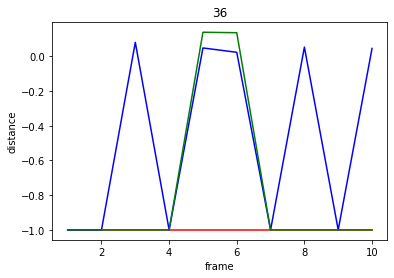

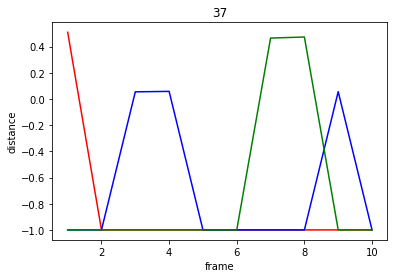

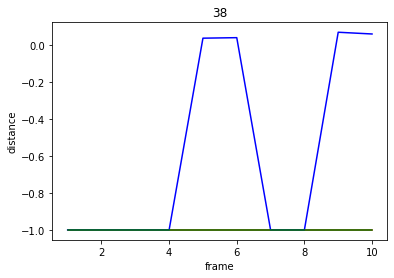

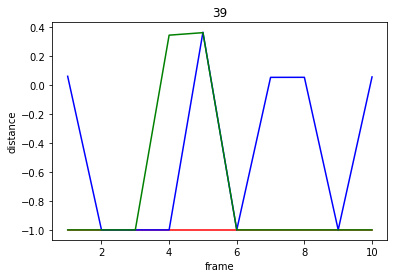

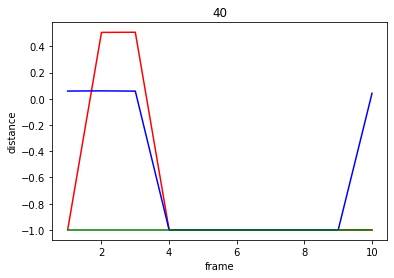

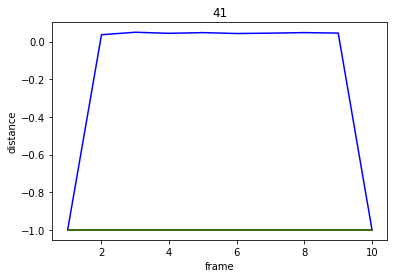

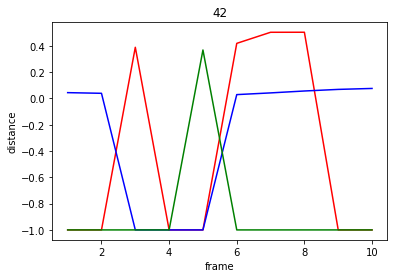

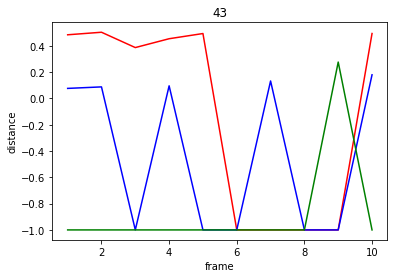

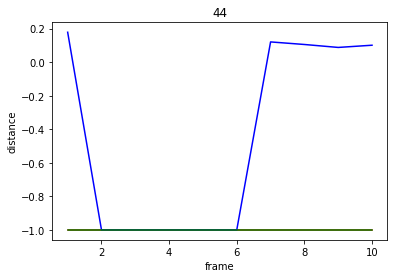

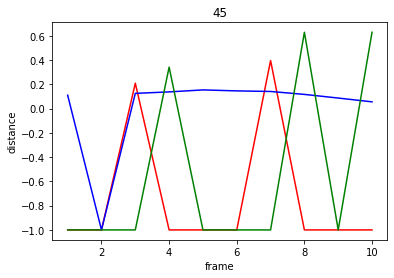

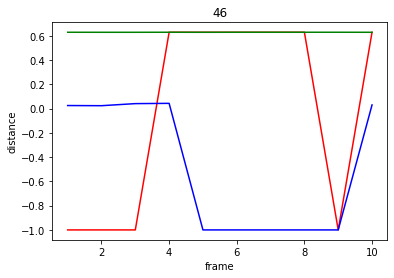

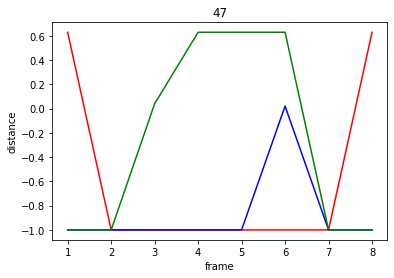

In [ ]:
draw_plot('/content/drive/Shareddrives/블루스크린_졸업작품/feature_list/general/output2.txt')
draw_plot('/content/drive/Shareddrives/블루스크린_졸업작품/feature_list/hack/output2.txt')

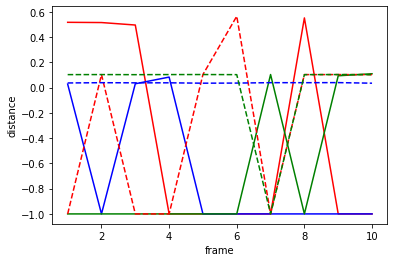

In [ ]:
#10프레임씩 잘라서 표로 비교(hack, general 둘 동시에)
file = open('/content/drive/Shareddrives/블루스크린_졸업작품/feature_list/general/output1.txt', 'rt')
file2 = open('/content/drive/Shareddrives/블루스크린_졸업작품/feature_list/hack/output1.txt', 'rt')
read_data_G = file.readlines()
read_data_H = file2.readlines()

num = 5

d_list = read_data_G[num].split(' ')
d_list2 = read_data_H[num].split(' ')
length = int((len(d_list) - 1) / 3)
frame = np.arange(1, length + 1, 1)
d0g, d1g, d2g, d0h, d1h, d2h = [], [], [], [], [], []
for i in range(len(d_list) - 1):
  if i < length:
    d0g.append(float(d_list[i]))
    d0h.append(float(d_list2[i]))
  elif i < 2 * length:
    d1g.append(float(d_list[i]))
    d1h.append(float(d_list2[i]))
  elif i < 3 * length:
    d2g.append(float(d_list[i]))
    d2h.append(float(d_list2[i]))

plt.plot(frame, d0g, 'r', frame, d1g, 'b', frame, d2g, 'g', frame, d0h, 'r--', frame, d1h, 'b--', frame, d2h, 'g--')
plt.xlabel('frame')
plt.ylabel('distance')
plt.show()

file.close()
file2.close()

['-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.012248579509477855', '-1', '-1', '-1', '0.23261746583822976', '0.10953305580052079', '0.1101306669234323', '0.11264078510024689', '0.11073537684498125', '0.10152785572442663', '0.10118413101371182', '0.08732492914397351', '0.06820247720574382', '0.06537631792170616', '0.09532606314119975', '0.09686734637121017', '0.05736280342695954', '0.055441003544308205', '0.02266091613328994', '0.0598221908157834', '0.0649649160162622', '0.019038532086271827', '0.024755365983963974', '0.0860632862781802', '0.16808324987636333', '0.027286515974011723', '-1', '0.030154363697481625', '0.08306767114226808', '-1', '-1', '-1', '-1', '-1', '0.12310658828836085', '0.11109067850184375', '-1', '0.042969455023307006', '-1', '0.15764858158892514', '0.18308084391874535', '0.1883303357242268', '0.187905593479811', '0.2787336883550318', '0.22257498220824368', '0.62909

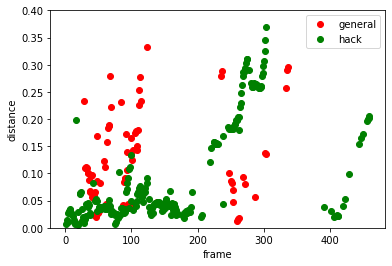

In [ ]:
#전체 프레임에 대해 비교. class 1에 대해서만
file = open('/content/drive/Shareddrives/블루스크린_졸업작품/test_result/general/output1.txt', 'rt')
file2 = open('/content/drive/Shareddrives/블루스크린_졸업작품/test_result/hack/output1.txt', 'rt')

num = 1 #0,1,2

read_data = file.readlines()
read_data2 = file2.readlines()
d_list = read_data[num].split(' ')
d_list2 = read_data2[num].split(' ')
print(d_list)
print(d_list2)
length = int(len(d_list) - 1)
length2 = int(len(d_list2) - 1)
print(length)
print(length2)
p_length = 0
if length < length2:
  p_length = length
else:
  p_length = length2
frame = np.arange(1, p_length+1, 1)
dg, dh = [], []
for i in range(p_length):
    dg.append(float(d_list[i]))
    dh.append(float(d_list2[i]))

plt.plot(frame, dg, 'ro', label='general')
plt.plot(frame, dh, 'go', label='hack')
plt.xlabel('frame')
plt.ylabel('distance')
plt.ylim([0.0, 0.4])
# plt.title('roadhog')
# plt.yticks([-1.0, 0, 0.2, 0.4, 0.6, 0.8])
plt.legend(loc='upper right')
#plt.show()
plt.savefig('/content/savefig5_200dpi.png', dpi=200)

file.close()
file2.close()

In [ ]:
for i in range(1, 11, 1):
  file = open('/content/drive/Shareddrives/블루스크린_졸업작품/test_result/general/output{}.txt'.format(i), 'rt')
  lines = file.readlines()
  print(len(lines))
  print(len(lines[0]), len(lines[1]), len(lines[2]))

3
5873 2872 6232
3
5737 6599 7557
3
5455 6235 5524
3
7615 2893 6058
3
6750 4377 6165
3
5301 4561 5570
3
5347 6614 4257
3
5958 7455 6313
3
6850 2826 5560
3
5360 5385 3588


In [ ]:
l = ['-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.012248579509477855', '-1', '-1', '-1', '0.23261746583822976', '0.10953305580052079', '0.1101306669234323', '0.11264078510024689', '0.11073537684498125', '0.10152785572442663', '0.10118413101371182', '0.08732492914397351', '0.06820247720574382', '0.06537631792170616', '0.09532606314119975', '0.09686734637121017', '0.05736280342695954', '0.055441003544308205', '0.02266091613328994', '0.0598221908157834', '0.0649649160162622', '0.019038532086271827', '0.024755365983963974', '0.0860632862781802', '0.16808324987636333', '0.027286515974011723', '-1', '0.030154363697481625', '0.08306767114226808', '-1', '-1', '-1', '-1', '-1', '0.12310658828836085', '0.11109067850184375', '-1', '0.042969455023307006', '-1', '0.15764858158892514', '0.18308084391874535', '0.1883303357242268', '0.187905593479811', '0.2787336883550318', '0.22257498220824368', '0.6290918562229605', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.23232864847022197', '-1', '0.042498003553108246', '-1', '0.08422160583247029', '0.09089022819313415', '0.08961944772202073', '0.1725167715962712', '0.13857090121666957', '0.10598171740918336', '0.04391811322222302', '-1', '-1', '0.04226339449216072', '0.16468695429814711', '0.1335451421280459', '0.12507260280732949', '0.14245063061987479', '-1', '-1', '-1', '0.17459009034020231', '0.1773203719881052', '0.15102451429155464', '0.14289303293372982', '0.17974736128522165', '0.2265145387033689', '0.2528398325126007', '0.2776066025907885', '0.23256638630722198', '-1', '-1', '0.6290918562229605', '-1', '0.6294201665188843', '-1', '-1', '-1', '0.332736216258465', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.04781226397065928', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.6305487168322048', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.6304509706307463', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.27846066751697623', '-1', '0.28912453480809963', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.10156583597352017', '-1', '-1', '0.08549306802893436', '0.08162032470530854', '0.06976674483591731', '0.04836425156042424', '-1', '-1', '-1', '-1', '0.012457138756552412', '-1', '0.01663778149273514', '0.017327085646466938', '-1', '-1', '-1', '-1', '-1', '0.09318676740825385', '-1', '-1', '-1', '0.08076342987392252', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.6296071181261692', '-1', '0.05698343215356549', '-1', '-1', '-1', '-1', '0.6299355130896575', '0.6299355130896575', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.1383116549138213', '0.13647837164913712', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.2566736101062982', '0.28941963287240896', '0.2966676997079392', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.561658420128284', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '0.589901346340564', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '\n']
len(l)

472

* 파일별 분산 데이터 구하기

In [ ]:
mei, roadhog, soldier76 = [], [], []
isHack = []
for i in range(1, 11, 1):
  vg0, vg1, vg2 = get_var('general', i)
  mei.append(vg0)
  roadhog.append(vg1)
  soldier76.append(vg2)
  isHack.append(0)
  vh0, vh1, vh2 = get_var('hack', i)
  mei.append(vh0)
  roadhog.append(vh1)
  soldier76.append(vh2)
  isHack.append(1)
  print('g{}: '.format(i), vg0, vg1, vg2)
  print('h{}: '.format(i), vh0, vh1, vh2)

g1:  0.3912517240255737 0.2160846376994545 0.3064982362713214
h1:  0.28430637073501847 0.308880021705873 0.40009385731387714
g2:  0.3577926651673147 0.26388861080190834 0.2666507317611844
h2:  0.3524925489500013 0.2969982163684441 0.42235416339741266
g3:  0.4639201310010466 0.2748816733404424 0.47706602214224797
h3:  0.3390927195044893 0.15149579467881535 0.474501939470262
g4:  0.2429509049186719 0.2190231575734025 0.29564333208124066
h4:  0.36463893800643066 0.2767568640278431 0.3219905107055088
g5:  0.30248630652063496 0.27386718720450365 0.3750919478060364
h5:  0.33807224960510557 0.20573609253668249 0.33748017458961704
g6:  0.37609588012622486 0.27685551734430786 0.37240879504836255
h6:  0.3280482213440613 0.2818647472322873 0.2935255966254057
g7:  0.4472682163616655 0.2655248787179294 0.4741225709483843
h7:  0.2660187144891259 0.1913823949379581 0.3864643971960318
g8:  0.3556811248977262 0.2152612675885154 0.38298391654150055
h8:  0.32394018296633226 0.29735326704031523 0.39516101

In [ ]:
print(len(mei), mei)
print(len(roadhog), roadhog)
print(len(soldier76), soldier76)
print(len(isHack), isHack)
# mei.clear()
# roadhog.clear()
# soldier76.clear()
# isHack.clear()

20 [0.3912517240255737, 0.28430637073501847, 0.3577926651673147, 0.3524925489500013, 0.4639201310010466, 0.3390927195044893, 0.2429509049186719, 0.36463893800643066, 0.30248630652063496, 0.33807224960510557, 0.37609588012622486, 0.3280482213440613, 0.4472682163616655, 0.2660187144891259, 0.3556811248977262, 0.32394018296633226, 0.29468265576417774, 0.36705794961759314, 0.4187434967095316, 0.4118119231031172]
20 [0.2160846376994545, 0.308880021705873, 0.26388861080190834, 0.2969982163684441, 0.2748816733404424, 0.15149579467881535, 0.2190231575734025, 0.2767568640278431, 0.27386718720450365, 0.20573609253668249, 0.27685551734430786, 0.2818647472322873, 0.2655248787179294, 0.1913823949379581, 0.2152612675885154, 0.29735326704031523, 0.18092523206300082, 0.1429877710234181, 0.2999609897887981, 0.26211700087419787]
20 [0.3064982362713214, 0.40009385731387714, 0.2666507317611844, 0.42235416339741266, 0.47706602214224797, 0.474501939470262, 0.29564333208124066, 0.3219905107055088, 0.37509194

In [ ]:
import pandas as pd
 
df = pd.DataFrame() ## 1. 데이터 초기화
 
## 2. 만들고자 하는 열(Column)의 이름과 데이터를 이용하여 열 데이터 생성
df['MEI'] = mei
df['ROADHOG'] = roadhog
df['SOLDIER-76'] = soldier76
df['isHack'] = isHack
df.to_csv('/content/drive/Shareddrives/블루스크린_졸업작품/test_result/variance.csv',index=False)

## 그 외 참고

### datasets 폴더에 데이터를 더 추가했을 때

roboflow에서 라벨링을 한다면 라벨 txt 파일이 생성되는데, 다른 프로젝트에서 작업한 내용을 export해서 그대로 추가해 작업하면 문제가 생김.
- dataset A, dataset B가 있다고 할 때, A는 1과 2, B는 3과 4라는 클래스를 구분하고 있다고 하자.
- 이때 컴퓨터에서 미리 다운받아 둔 datasets A에 B 내용을 추가하려고 한다.
- A는 1과 2라는 클래스를 0, 1로 구분함.
- B도 3과 4라는 클래스를 0, 1로 구분함.
- 따라서 라벨 txt 파일 내용을 변경해 줄 필요가 있음.
- txt 파일을 열면 띄워쓰기로 구분된 숫자들 중 가장 첫번째 숫자가 클래스를 나타냄. 이것을 변경해 주자.

In [ ]:
# train 폴더 내에 몇개의 라벨파일이 있나 세는 코드
from glob import glob
import os
train_label_list = glob('./train/labels/*.txt')
count = 0
for path in train_label_list:
    print(path)
    count = count + 1

print(count)

In [ ]:
# train 폴더 내 label 파일 내용을 바꿔주는 코드 (아래 예시의 경우 0을 1로 바꿔준다.)
from glob import glob 
import os 
train_label_list = glob('./train/labels/*.txt')
for path in train_label_list:
    print(path)
    f = open(path, "rt")
    newText = f.read()
    if newText.startswith("0"):
        f2 = open(path, 'wt')
        f2.write(newText.replace(newText[0], '1', 1))
        f2.close()
    f.close()

In [ ]:
# 위 코드와 마찬가지. valid 폴더 내 label 파일 내용을 바꿔주는 코드 (아래 예시의 경우 0을 1로 바꿔준다.)
from glob import glob 
import os 
train_label_list = glob('./valid/labels/*.txt')
for path in train_label_list:
    print(path)
    f = open(path, "rt")
    newText = f.read()
    if newText.startswith("0"):
        f2 = open(path, 'wt')
        f2.write(newText.replace(newText[0], '1', 1))
        f2.close()
    f.close()

---

#기타 더미코드
- 파일 옮기기
- 파일 수 세기
- 폴더 삭제
- 드라이브로 복사
-...

In [ ]:
%cd /content/yolov5/datasets

/content/yolov5/datasets


%rm 사용시 주의
- 반드시 cd로 삭제할 파일 상위폴더로 빠져나온 뒤 삭제할 것.
- 절대경로 말고 상대경로로 삭제하자 -> 관련있는지는 모르겠다

In [ ]:
%rm -rf ./datasets

In [ ]:
%cp -r /content/yolov5/datasets/datasets/train/images/* /content/yolov5/datasets/train/images/

In [ ]:
# train 폴더 내에 몇개의 라벨파일이 있나 세는 코드
from glob import glob
import os
train_label_list = glob('/content/yolov5/datasets/train/images/*.jpg')
count = 0
for path in train_label_list:
    #print(path)
    count = count + 1

print(count)

7742
